In [1]:
# Loading all needed packages at the start
import elastix 
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import shutil
from PIL import Image

from FunctionsImageRegistration import *


## Fill in your own paths in the cell below ##

In [2]:
# to Elastix.exe
ELASTIX_PATH = r'C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe'
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)
# to Transformix.exe
TRANSFORMIX_PATH = r'C:\Users\20191679\Documents\Master\CS_image_analysis\Transformix.exe'
# to TrainingData
filepath_data = r'C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData'

### Default settings


In [3]:
# default settings for MI computation
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'


#### TO DO: Test out hypothesis: does the nr of bins in the MI computation function ever influence the order of the highest MI values?

## Per manually selected fixed image, find the five most similar moving image slices and perform B-spline transformation on them:


In [36]:
# Test set containing p119, p128, and p135 are left out!

patient_nrs_list = ['p102','p107', 'p108', 'p109', 'p115', 'p116', 'p117', 'p120', 'p125', 'p127', 'p129', 'p133']
#                    0      1       2       3       4       5       6       7       8       9       10      11       

# load all 12 patients' data (every 3D array) in one list, which has the same order as 'patient_nrs_list'
loaded_mr_list = []
for value in patient_nrs_list:
    loaded_mr, __ = loadPatientDataReadable(value, filepath=filepath_data)
    loaded_mr_list.append(loaded_mr)




In [ ]:
# Generate 2D arrays for all patients
for patient_id in range(len(patient_nrs_list)):
    patient_id_fixed_image= patient_nrs_list[patient_id]
    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image
    fixed_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_id_fixed_image) # path to fixed image
    create2DImages(fixed_image_path, patient_id_fixed_image, filepath_data)
    create2DMasks(fixed_mask_path,patient_id_fixed_image, filepath_data)

print('Done creating 2D arrays')

In [37]:
# # Select (for now manually) which image is currently your fixed image -- # Enter image level of one fixed image
# fixed_image_index = 5 # index in patient_nrs_list
# patient_id_fixed_image = patient_nrs_list[fixed_image_index] # patient ID (for example 'p102') of fixed image
    
    
    
for fixed_image_index in range(len(patient_nrs_list)):
    patient_id_fixed_image = patient_nrs_list[fixed_image_index] # patient ID (for example 'p102') of fixed image
    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image
    
    patient_nrs_moving= patient_nrs_list

    print('Patient selected as fixed image:', patient_id_fixed_image)

    # select all but fixed image to use as moving image
    train_mr_list_moving = []
    for j in loaded_mr_list:
        train_mr_list_moving.append(j)

    fixed_image_mr = train_mr_list_moving.pop(fixed_image_index) # 3D array of fixed image
    
    patient_nrs_moving.pop(fixed_image_index)
    

    # # # # Enter slice iterator of fixed image # # # # 

    for image_slice_fixed in range(86): # when everything works: use 86. When everything is still being tested: keep it simple with 4. 

        print('Fixed image slice nr:', image_slice_fixed)

        list_of_list_MI, list_moving_slices_used = allMImovingImages(train_mr_list_moving, image_slice_fixed, fixed_image_mr)
        
        per_patient_per_slice_MI = intoOneList(list_of_list_MI)

        most_similar_list_index = sort_index(per_patient_per_slice_MI)[:5] # Get the five most similar images of all moving images

        patient_ids_similar = []
        slice_ids_similar = []
        for j in most_similar_list_index:
            patient_index_a, actual_slice_nr_a = getPatientAndSlice(j, list_moving_slices_used, train_mr_list_moving, patient_nrs_list, patient_nrs_moving)
            patient_ids_similar.append(patient_nrs_moving[patient_index_a])
            slice_ids_similar.append(actual_slice_nr_a)

        #Initialize segmentations list
        seg_data=[]

        # Perform B-spline registration for each most similar slice and store the results
        # # # # Enter iterator for most similar slices (paired with correct patient) # # # #
        for work_down_list in range(len(patient_ids_similar)): # 0 to 5
            bspline_registration(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data, el_path=el)

            ## Visualization of results, can test below independently
            #visualize_bspline_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)
            #visualize_jacobian(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data, tr_path=TRANSFORMIX_PATH)

            # Create a new parameter file
            newTransformParameterFile(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data)

            # Bspline registration of masks
            bspline_mask_registration(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data, TRANSFORMIX_PATH)

            ##Visualization of masks, can test down below independently
            #visualize_bspline_mask_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)

            ## Overlay masks, can test down below independently
            #overlay_mask(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)


            #Save segmentation, maybe we could put this in a function as well but this works too
            output_path_mask = os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(
                    patient_id_fixed_image,image_slice_fixed, patient_ids_similar[work_down_list],slice_ids_similar[work_down_list]))
            file_p_mask=os.path.join(output_path_mask, 'result.mhd')
            
            readable_mask=imageio.imread(file_p_mask)
            seg_data.append(readable_mask)

        # STAPLE
        combined_seg = Atlas(seg_data)
        
        #get extrema
        img_seg = Image.fromarray(combined_seg)
        extrema=img_seg.getextrema()
        
        if extrema[0]==1.0 and extrema[1]==1.0:
            combined_seg=np.zeros(np.shape(combined_seg))

        # Save the result
        image_path=os.path.join(filepath_data, patient_id_fixed_image)
        img_name= 'result_{}_slice{}.png'.format(patient_id_fixed_image, image_slice_fixed)
        img = Image.fromarray(combined_seg*255)
        img = img.convert("L")
        img.save(os.path.join(image_path,img_name))

    #     #Evaluation
    #     fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed) # path to fixed image
    #     result_path=os.path.join(filepath_data,patient_id_fixed_image, 'result_{}_slice{}.png'.format(patient_id_fixed_image,image_slice_fixed))

    #     dice_coeff= diceFunction(result_path, fixed_mask_path)
    #     quality= computeQualityMeasures(result_path, fixed_mask_path)
    #     print(dice_coeff, quality)

Patient selected as fixed image: p102
Fixed image slice nr: 0
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice0.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice0.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\bspline_results_slice_0\moving_slice_p116_0
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice0.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice1.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\bspline_results_slice_0\moving_slice_p129_1
C:\Users\20191679\Docume

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice3.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice2.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\bspline_results_slice_3\moving_slice_p116_2
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice3.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice5.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\bspline_results_slice_3\moving_slice_p129_5
Fixed image slice nr: 4
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.e

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice7.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice4.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\bspline_results_slice_7\moving_slice_p116_4
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice7.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice3.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\bspline_results_slice_7\moving_slice_p116_3
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\

KeyboardInterrupt: 

In [35]:
## Evaluation separately, could put this in a function but this works as well
dice_coeffs=[]
hausdorff_95=[]
both_black=0
one_black = 0

#for patient_id in patient_nrs_list:
for patient_id in ['p107']:
    for slice_id in range(86):
        fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id, patient_id, slice_id) # path to fixed image
        result_path=os.path.join(filepath_data,patient_id, 'result_{}_slice{}.png'.format(patient_id,slice_id))
        
        dice_coeff= diceFunction(result_path, fixed_mask_path)
        dice_coeffs.append(dice_coeff)
        
        #get extrema result
        readable_im_result = imageio.imread(result_path)
        img_result = Image.fromarray(readable_im_result)
        extrema_result = img_result.getextrema()
        
        #get extrema original image
        readable_im_orig = imageio.imread(fixed_mask_path)
        img_orig = Image.fromarray(readable_im_orig)
        extrema_orig = img_orig.getextrema()
             
        # do not calculate Hausdorff distance if segmentation is black

        if extrema_result[1]== 0 and extrema_orig[1]==0:
            both_black += 1

        else:
            if extrema_result[1] == 0 and extrema_orig[1] != 0:
                one_black += 1
            if extrema_result[1] != 0 and extrema_orig[1] == 0:
                one_black += 1
                
        if extrema_result[0] != extrema_result[1] and extrema_orig[1] != 0:
            quality= computeQualityMeasures(result_path, fixed_mask_path)
            hausdorff_95.append(quality.get('hausdorff_95'))

print(both_black, one_black)

avg_dice= np.mean(dice_coeffs)
avg_hausdorff_95=np.mean(hausdorff_95)
print(dice_coeffs)
print(avg_dice)
#print(hausdorff_95)
print(avg_hausdorff_95)

2 34
[1.0, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.1081191892877219e-11, 1.0, 1.834862381954381e-09, 6.393861888494972e-10, 9.689922471230694e-10, 9.970089720867308e-10, 1.0245901628846412e-09, 4.755111742864901e-10, 0.16471477175492452, 0.205284553114741, 0.13934894358375943, 0.3226366003203303, 0.4411090265913885, 0.4489923450321836, 0.6287054095413321, 0.762397991248839, 0.8517022504541688, 0.8534031413804446, 0.8361554972768716, 0.8538531691913072, 0.8896898208945293, 0.8859074

In [24]:
## Visualization of results separately
for fixed_image_id in range(1):
    #fixed_image_id=0
    patient_id_fixed_image= patient_nrs_list[fixed_image_id]
    
    patient_nrs_moving= patient_nrs_list


    # select all but fixed image to use as moving image
    train_mr_list_moving = []
    for j in loaded_mr_list:
        train_mr_list_moving.append(j)

    fixed_image_mr = train_mr_list_moving.pop(fixed_image_id) # 3D array of fixed image
    patient_nrs_moving.pop(fixed_image_index)

    for image_slice_fixed in range(86): # when everything works: use 86. When everything is still being tested: keep it simple with 4. 

        #First get most similar slices (again)
#         print('Fixed image slice nr:', image_slice_fixed)

        list_of_list_MI, list_moving_slices_used = allMImovingImages(train_mr_list_moving, image_slice_fixed, fixed_image_mr)

        per_patient_per_slice_MI = intoOneList(list_of_list_MI)

        most_similar_list_index = sort_index(per_patient_per_slice_MI)[:5] # Get the five most similar images of all moving images

        patient_ids_similar = []
        slice_ids_similar = []
        for j in most_similar_list_index:
            patient_index_a, actual_slice_nr_a = getPatientAndSlice(j, list_moving_slices_used, train_mr_list_moving, patient_nrs_list, patient_nrs_moving)
            patient_ids_similar.append(patient_nrs_moving[patient_index_a])
            slice_ids_similar.append(actual_slice_nr_a)


    #     # Visualization of results
    #     #registration
    #     for work_down_list in range(len(patient_ids_similar)): # 0 to 5
    #         visualize_bspline_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
    #                              slice_ids_similar[work_down_list], filepath_data)
    #     #jacobian
    #     for work_down_list in range(len(patient_ids_similar)): # 0 to 5
    #         visualize_jacobian(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
    #                              slice_ids_similar[work_down_list], filepath_data, tr_path=TRANSFORMIX_PATH)
    #     #mask registration
    #     for work_down_list in range(len(patient_ids_similar)): # 0 to 5    
    #         visualize_bspline_mask_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
    #                              slice_ids_similar[work_down_list], filepath_data)
#         #mask overlay
#         for work_down_list in range(len(patient_ids_similar)): # 0 to 5    
#             overlay_mask(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
#                                  slice_ids_similar[work_down_list], filepath_data)
        
        #combined segmentation, overlays the masks over the original image
        #could also put this into a function    
        fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed) 
        result_path=os.path.join(filepath_data,patient_id_fixed_image, 'result_{}_slice{}.png'.format(patient_id_fixed_image,image_slice_fixed))
        fixed_image_path = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed)

        readable_fixed = imageio.imread(fixed_image_path)

        itk_mask_fixed = sitk.ReadImage(fixed_mask_path)
        mask_array_fixed = sitk.GetArrayFromImage(itk_mask_fixed)

        itk_mask_result= sitk.ReadImage(result_path)
        mask_array_result = sitk.GetArrayFromImage(itk_mask_result)

        fig,ax=plt.subplots(1,2)
        ax[0].imshow(readable_fixed[:,:], cmap='gray')
        ax[0].imshow(mask_array_fixed[:,:], cmap='gray', alpha=0.5)
        ax[0].set_title('Ground truth, \nslice {}, {}'.format(image_slice_fixed, patient_id_fixed_image))
        ax[1].imshow(readable_fixed[:,:], cmap='gray')
        ax[1].imshow(mask_array_result, cmap='gray', alpha=0.5)
        ax[1].set_title('Combined segmentation, \nslice {}, {}'.format(image_slice_fixed, patient_id_fixed_image))


TypeError: getPatientAndSlice() missing 1 required positional argument: 'list_ids_moving'

## Validate on independent test set

In [40]:
test_pts=['p119', 'p128', 'p135']

# Test set containing p119, p128, and p135 are left out!

#patient_nrs_list = ['p102','p107', 'p108', 'p109', 'p115', 'p116', 'p117', 'p120', 'p125', 'p127', 'p129', 'p133']
#                    0      1       2       3       4       5       6       7       8       9       10      11       

# load all 12 patients' data (every 3D array) in one list, which has the same order as 'patient_nrs_list'
loaded_mr_list_test = []
for value in test_pts:
    loaded_mr_test, __ = loadPatientDataReadable(value, filepath=filepath_data)
    loaded_mr_list_test.append(loaded_mr_test)

In [39]:
# Generate 2D arrays for all patients
for patient_id in range(len(test_pts)):
    patient_id_fixed_image= test_pts[patient_id]
    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image
    #fixed_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_id_fixed_image) # path to fixed image
    create2DImages(fixed_image_path, patient_id_fixed_image, filepath_data)
    #create2DMasks(fixed_mask_path,patient_id_fixed_image, filepath_data)

print('Done creating 2D arrays')

NameError: name 'test_pts' is not defined

In [43]:

    
    
#for fixed_image_index in range(len(test_pts)):
for fixed_image_index in range(3):
    patient_id_fixed_image = test_pts[fixed_image_index] # patient ID (for example 'p102') of fixed image
    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image

    print('Patient selected as fixed image:', patient_id_fixed_image)

    # select all but fixed image to use as moving image
    train_mr_list_moving = []
    for j in loaded_mr_list:
        train_mr_list_moving.append(j)
        
    fixed_image_mr_test, __= loadPatientDataReadable(patient_id_fixed_image, filepath=filepath_data)


    # # # # Enter slice iterator of fixed image # # # # 

    for image_slice_fixed in range(86): # when everything works: use 86. When everything is still being tested: keep it simple with 4. 

        print('Fixed image slice nr:', image_slice_fixed)
        list_of_list_MI, list_moving_slices_used = allMImovingImages(train_mr_list_moving, image_slice_fixed, fixed_image_mr_test)

        per_patient_per_slice_MI = intoOneList(list_of_list_MI)
        
        most_similar_list_index = sort_index(per_patient_per_slice_MI)[:5] # Get the five most similar images of all moving images

        patient_ids_similar = []
        slice_ids_similar = []
        for j in most_similar_list_index:
            patient_index_a, actual_slice_nr_a = getPatientAndSlice(j, list_moving_slices_used, train_mr_list_moving, patient_nrs_list, patient_nrs_list)
            patient_ids_similar.append(patient_nrs_list[patient_index_a])
            slice_ids_similar.append(actual_slice_nr_a)

        #Initialize segmentations list
        seg_data=[]

        # Perform B-spline registration for each most similar slice and store the results
        # # # # Enter iterator for most similar slices (paired with correct patient) # # # #
        for work_down_list in range(len(patient_ids_similar)): # 0 to 5                  
                               
            bspline_registration(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data, el_path=el)

            ## Visualization of results, can test below independently
            #visualize_bspline_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)
            #visualize_jacobian(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data, tr_path=TRANSFORMIX_PATH)

            # Create a new parameter file
            newTransformParameterFile(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data)

            # Bspline registration of masks
            bspline_mask_registration(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data, TRANSFORMIX_PATH)

            ##Visualization of masks, can test down below independently
            #visualize_bspline_mask_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)

            ## Overlay masks, can test down below independently
            #overlay_mask(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)


            #Save segmentation, maybe we could put this in a function as well but this works too
            output_path_mask = os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(
                    patient_id_fixed_image,image_slice_fixed, patient_ids_similar[work_down_list],slice_ids_similar[work_down_list]))
            file_p_mask=os.path.join(output_path_mask, 'result.mhd')
            readable_mask=imageio.imread(file_p_mask)
            seg_data.append(readable_mask)

        # STAPLE
        combined_seg = Atlas(seg_data)
        #plt.imshow(combined_seg)
        
        img_seg = Image.fromarray(combined_seg)
        extrema=img_seg.getextrema()
        
        if extrema[0]==1.0 and extrema[1]==1.0:
            combined_seg=np.zeros(np.shape(combined_seg))

        # Save the result
        image_path=os.path.join(filepath_data, patient_id_fixed_image)
        img_name= 'result_{}_slice{}.png'.format(patient_id_fixed_image, image_slice_fixed)
        img = Image.fromarray(combined_seg*255)
        img = img.convert("L")
        img.save(os.path.join(image_path,img_name))

    #     #Evaluation
    #     fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed) # path to fixed image
    #     result_path=os.path.join(filepath_data,patient_id_fixed_image, 'result_{}_slice{}.png'.format(patient_id_fixed_image,image_slice_fixed))

    #     dice_coeff= diceFunction(result_path, fixed_mask_path)
    #     quality= computeQualityMeasures(result_path, fixed_mask_path)
    #     print(dice_coeff, quality)

Patient selected as fixed image: p119
Fixed image slice nr: 0
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice0.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice0.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_0\moving_slice_p117_0
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice0.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice1.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_0\moving_slice_p117_1
C:\Users\20191679\Docume

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice3.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice1.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_3\moving_slice_p116_1
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice3.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice3.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_3\moving_slice_p117_3
Fixed image slice nr: 4
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.e

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice7.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice1.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_7\moving_slice_p117_1
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice7.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice2.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_7\moving_slice_p117_2
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice10.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice18.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_10\moving_slice_p129_18
Fixed image slice nr: 11
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice11.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice2.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_11\moving_slice_p117_2
C:\Users\20191679\Documents\Master\CS_image_analysis\El

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice14.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice18.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_14\moving_slice_p129_18
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice14.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice23.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_14\moving_slice_p129_23
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 18
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice18.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice25.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_18\moving_slice_p108_25
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice18.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice24.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_18\moving_slice_p108_24
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice21.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice23.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_21\moving_slice_p108_23
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice21.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice22.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_21\moving_slice_p108_22
Fixed image slice nr: 22
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice25.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice25.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_25\moving_slice_p108_25
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice25.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice26.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_25\moving_slice_p108_26
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice28.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice27.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_28\moving_slice_p108_27
Fixed image slice nr: 29
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice29.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice25.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_29\moving_slice_p108_25
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice32.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice24.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_32\moving_slice_p108_24
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice32.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice27.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_32\moving_slice_p108_27
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 36
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice36.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice27.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_36\moving_slice_p108_27
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice36.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice28.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_36\moving_slice_p108_28
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice39.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice40.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_39\moving_slice_p129_40
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice39.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice41.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_39\moving_slice_p129_41
Fixed image slice nr: 40
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice43.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice40.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_43\moving_slice_p129_40
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice43.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice39.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_43\moving_slice_p129_39
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice46.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice40.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_46\moving_slice_p129_40
Fixed image slice nr: 47
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice47.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice51.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_47\moving_slice_p116_51
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice50.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice52.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_50\moving_slice_p116_52
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice50.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice49.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_50\moving_slice_p116_49
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 54
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice54.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice51.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_54\moving_slice_p116_51
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice54.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice63.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_54\moving_slice_p129_63
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice57.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice66.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_57\moving_slice_p116_66
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice57.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice59.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_57\moving_slice_p116_59
Fixed image slice nr: 58
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice61.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice65.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_61\moving_slice_p108_65
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice61.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice60.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_61\moving_slice_p129_60
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice64.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice63.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_64\moving_slice_p129_63
Fixed image slice nr: 65
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice65.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice59.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_65\moving_slice_p129_59
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice68.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice63.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_68\moving_slice_p129_63
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice68.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice66.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_68\moving_slice_p129_66
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 72
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice72.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice66.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_72\moving_slice_p129_66
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice72.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice65.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_72\moving_slice_p129_65
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice75.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice75.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_75\moving_slice_p129_75
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice75.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice74.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_75\moving_slice_p129_74
Fixed image slice nr: 76
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice79.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice75.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_79\moving_slice_p129_75
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice79.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice71.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_79\moving_slice_p116_71
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice82.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice74.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_82\moving_slice_p129_74
Fixed image slice nr: 83
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\p119_slice83.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice85.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p119\bspline_results_slice_83\moving_slice_p108_85
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice0.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice6.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_0\moving_slice_p116_6
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice0.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice8.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_0\moving_slice_p116_8
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\

Fixed image slice nr: 4
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice4.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice4.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_4\moving_slice_p109_4
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice4.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice3.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_4\moving_slice_p109_3
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.e

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice7.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice5.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_7\moving_slice_p109_5
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice7.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice6.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_7\moving_slice_p109_6
Fixed image slice nr: 8
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.e

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice11.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice6.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_11\moving_slice_p109_6
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice11.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice3.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_11\moving_slice_p108_3
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice14.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice6.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_14\moving_slice_p109_6
Fixed image slice nr: 15
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice15.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice17.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_15\moving_slice_p109_17
C:\Users\20191679\Documents\Master\CS_image_analysis\El

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice18.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice19.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_18\moving_slice_p109_19
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice18.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice16.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_18\moving_slice_p109_16
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 22
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice22.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice17.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_22\moving_slice_p109_17
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice22.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice18.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_22\moving_slice_p109_18
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice25.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice19.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_25\moving_slice_p109_19
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice25.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice20.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_25\moving_slice_p109_20
Fixed image slice nr: 26
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice29.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice21.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_29\moving_slice_p109_21
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice29.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p109\p109_slice22.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_29\moving_slice_p109_22
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice32.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice31.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_32\moving_slice_p129_31
Fixed image slice nr: 33
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice33.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice31.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_33\moving_slice_p129_31
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice36.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice34.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_36\moving_slice_p129_34
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice36.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice31.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_36\moving_slice_p129_31
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 40
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice40.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice34.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_40\moving_slice_p129_34
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice40.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice32.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_40\moving_slice_p129_32
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice43.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice37.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_43\moving_slice_p129_37
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice43.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice38.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_43\moving_slice_p129_38
Fixed image slice nr: 44
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice47.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice39.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_47\moving_slice_p129_39
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice47.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice40.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_47\moving_slice_p129_40
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice50.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice55.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_50\moving_slice_p116_55
Fixed image slice nr: 51
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice51.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice58.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_51\moving_slice_p116_58
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice54.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice59.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_54\moving_slice_p116_59
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice54.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice57.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_54\moving_slice_p116_57
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 58
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice58.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice64.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_58\moving_slice_p116_64
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice58.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice60.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_58\moving_slice_p116_60
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice61.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice60.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_61\moving_slice_p116_60
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice61.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice61.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_61\moving_slice_p116_61
Fixed image slice nr: 62
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice65.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice64.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_65\moving_slice_p116_64
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice65.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice66.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_65\moving_slice_p116_66
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice68.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice73.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_68\moving_slice_p129_73
Fixed image slice nr: 69
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice69.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice70.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_69\moving_slice_p108_70
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice72.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice73.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_72\moving_slice_p108_73
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice72.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice70.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_72\moving_slice_p108_70
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 76
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice76.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice73.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_76\moving_slice_p108_73
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice76.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice74.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_76\moving_slice_p108_74
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice79.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice77.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_79\moving_slice_p108_77
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice79.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice78.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_79\moving_slice_p108_78
Fixed image slice nr: 80
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice83.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice84.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_83\moving_slice_p108_84
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\p128_slice83.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice83.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p128\bspline_results_slice_83\moving_slice_p108_83
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice0.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p127\p127_slice6.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_0\moving_slice_p127_6
Fixed image slice nr: 1
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice1.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p127\p127_slice6.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_1\moving_slice_p127_6
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.e

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice4.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice8.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_4\moving_slice_p108_8
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice4.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p127\p127_slice4.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_4\moving_slice_p127_4
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\

Fixed image slice nr: 8
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice8.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice8.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_8\moving_slice_p108_8
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice8.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice9.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_8\moving_slice_p108_9
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.e

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice11.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice8.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_11\moving_slice_p117_8
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice11.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice12.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_11\moving_slice_p117_12
Fixed image slice nr: 12
C:\Users\20191679\Documents\Master\CS_image_analysis\El

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice15.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice11.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_15\moving_slice_p117_11
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice15.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice7.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_15\moving_slice_p117_7
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\201

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice18.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice13.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_18\moving_slice_p117_13
Fixed image slice nr: 19
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice19.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice11.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_19\moving_slice_p117_11
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice22.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice15.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_22\moving_slice_p117_15
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice22.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice16.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_22\moving_slice_p117_16
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 26
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice26.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice18.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_26\moving_slice_p117_18
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice26.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice17.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_26\moving_slice_p117_17
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice29.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice23.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_29\moving_slice_p117_23
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice29.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice24.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_29\moving_slice_p117_24
Fixed image slice nr: 30
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice33.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice25.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_33\moving_slice_p117_25
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice33.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice26.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_33\moving_slice_p117_26
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice36.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice30.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_36\moving_slice_p129_30
Fixed image slice nr: 37
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice37.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p117\p117_slice28.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_37\moving_slice_p117_28
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice40.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice33.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_40\moving_slice_p129_33
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice40.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p127\p127_slice49.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_40\moving_slice_p127_49
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 44
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice44.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice35.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_44\moving_slice_p129_35
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice44.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice40.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_44\moving_slice_p129_40
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice47.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice39.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_47\moving_slice_p129_39
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice47.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice38.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_47\moving_slice_p129_38
Fixed image slice nr: 48
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice51.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice58.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_51\moving_slice_p116_58
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice51.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice56.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_51\moving_slice_p116_56
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice54.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice63.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_54\moving_slice_p116_63
Fixed image slice nr: 55
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice55.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice64.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_55\moving_slice_p116_64
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice58.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice56.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_58\moving_slice_p116_56
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice58.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice57.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_58\moving_slice_p116_57
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 62
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice62.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice67.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_62\moving_slice_p116_67
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice62.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice68.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_62\moving_slice_p116_68
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice65.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice65.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_65\moving_slice_p129_65
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice65.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice64.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_65\moving_slice_p129_64
Fixed image slice nr: 66
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice69.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice67.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_69\moving_slice_p129_67
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice69.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice69.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_69\moving_slice_p129_69
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice72.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice70.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_72\moving_slice_p129_70
Fixed image slice nr: 73
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice73.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p129\p129_slice68.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_73\moving_slice_p129_68
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice76.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice74.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_76\moving_slice_p108_74
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice76.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice75.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_76\moving_slice_p108_75
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\2

Fixed image slice nr: 80
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice80.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice80.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_80\moving_slice_p108_80
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice80.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice79.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_80\moving_slice_p108_79
C:\Users\20191679\Documents\Master\CS_image_analysis\

C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice83.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice83.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_83\moving_slice_p108_83
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\p135_slice83.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p108\p108_slice85.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p135\bspline_results_slice_83\moving_slice_p108_85
Fixed image slice nr: 84
C:\Users\20191679\Documents\Master\CS_image_analysis\

In [44]:
# Generate 2D arrays of masks
for patient_id in range(len(test_pts)):
    patient_id_fixed_image= test_pts[patient_id]
    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image
    fixed_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_id_fixed_image) # path to fixed image
    create2DMasks(fixed_mask_path,patient_id_fixed_image, filepath_data)

print('Done creating 2D arrays')

Done creating 2D arrays


In [45]:
## Evaluation separately, could put this in a function but this works as well
dice_coeffs=[]
hausdorff_95=[]
both_black=0
one_black = 0

#for patient_id in patient_nrs_list:
for patient_id in test_pts:
    for slice_id in range(86):
        fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id, patient_id, slice_id) # path to fixed image
        result_path=os.path.join(filepath_data,patient_id, 'result_{}_slice{}.png'.format(patient_id,slice_id))
        
        dice_coeff= diceFunction(result_path, fixed_mask_path)
        dice_coeffs.append(dice_coeff)
        
        #get extrema result
        readable_im_result = imageio.imread(result_path)
        img_result = Image.fromarray(readable_im_result)
        extrema_result = img_result.getextrema()
        
        #get extrema original image
        readable_im_orig = imageio.imread(fixed_mask_path)
        img_orig = Image.fromarray(readable_im_orig)
        extrema_orig = img_orig.getextrema()
             
        # do not calculate Hausdorff distance if segmentation is black

        if extrema_result[1]== 0 and extrema_orig[1]==0:
            both_black += 1

        else:
            if extrema_result[1] == 0 and extrema_orig[1] != 0:
                one_black += 1
            if extrema_result[1] != 0 and extrema_orig[1] == 0:
                one_black += 1
                
        if extrema_result[0] != extrema_result[1] and extrema_orig[1] != 0:
            quality= computeQualityMeasures(result_path, fixed_mask_path)
            hausdorff_95.append(quality.get('hausdorff_95'))

print(both_black, one_black)

avg_dice= np.mean(dice_coeffs)
avg_hausdorff_95=np.mean(hausdorff_95)
print(dice_coeffs)
print(avg_dice)
#print(hausdorff_95)
print(avg_hausdorff_95)

77 35
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.924831821314761e-10, 2.748763055868949e-10, 2.5239777883584106e-10, 2.635740642426004e-10, 3.0248033868648505e-10, 2.681684096894158e-10, 1.368925393378655e-10, 1.1640088463317414e-10, 1.245485116297735e-10, 1.1559357298397946e-10, 0.15850302706015376, 0.17531896181529708, 0.38229301733982346, 0.42739488521494073, 0.34718676612404914, 0.40242827774381396, 0.47752864977802406, 0.38436576048284665, 0.40335915634376934, 0.6647433346931214, 0.8743249877424736, 0.866613870362415, 0.8804695837907717, 0.7264319325226001, 0.7428571428772714, 0.7263897190879864, 0.7023801451344422, 0.6392444672219808, 0.6729552643655131, 0.7074953260604218, 0.6822696534402859, 0.7012812564733787, 0.7137884062502503, 0.6510835372399911, 0.8822264830700002, 0.8411802994228043, 0.7796337075149238, 0.8813732155063804, 0.8784518373625543, 0.8219666931095377, 0.7627507443133998, 0.83386398038343, 0.8364241987830202, 0.8900636997924313, 0.9093442480227578, 0.8

C:\Users\20191679\AppData\Local\Temp\ipykernel_21312\2570995624.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,2)


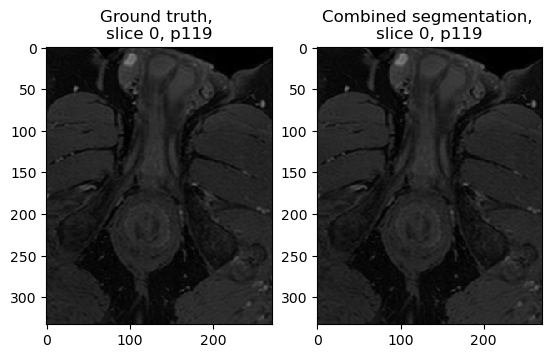

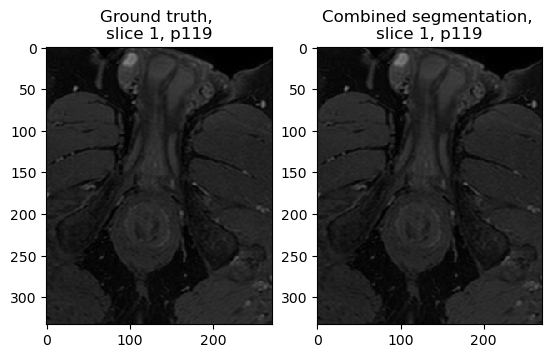

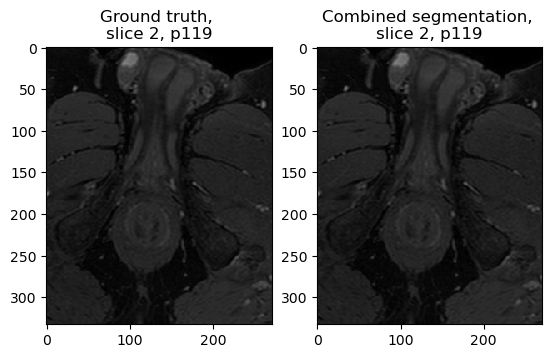

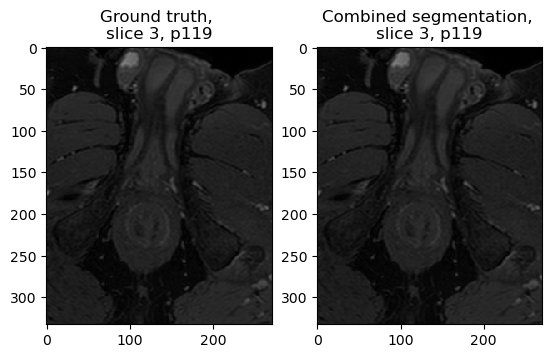

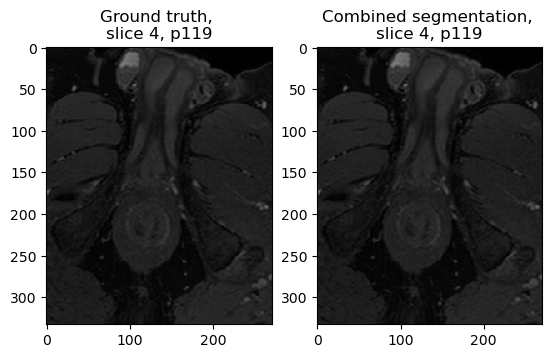

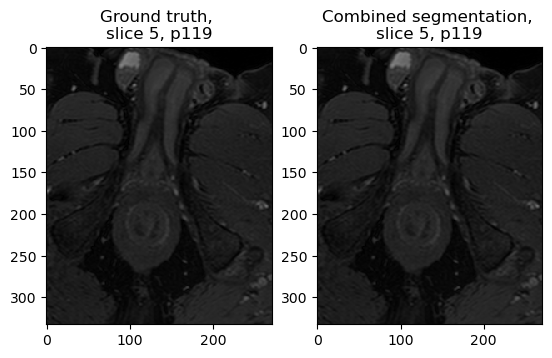

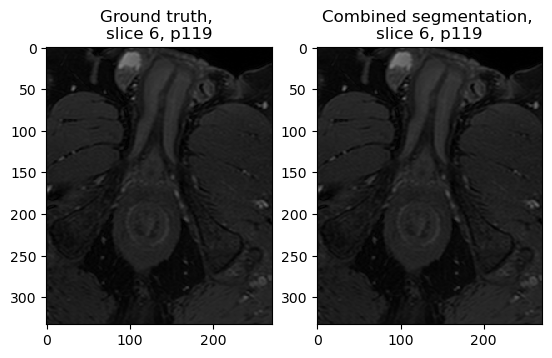

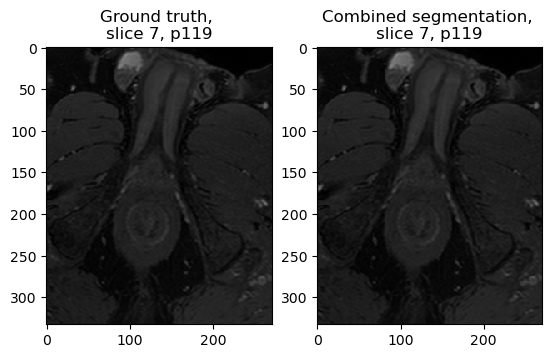

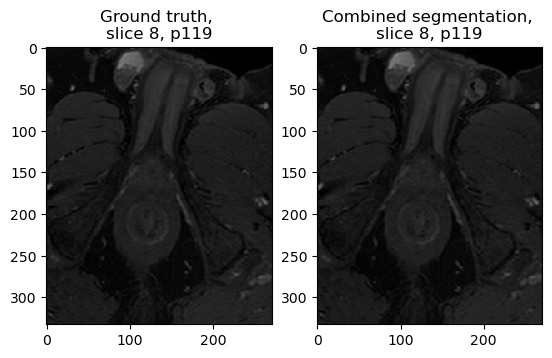

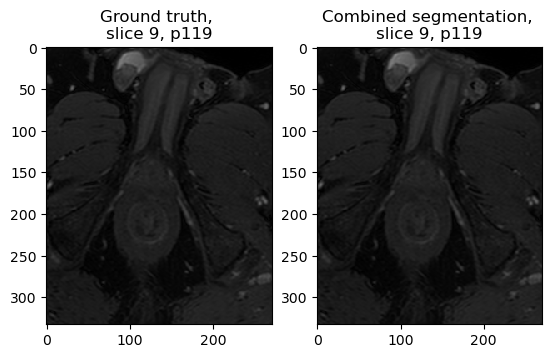

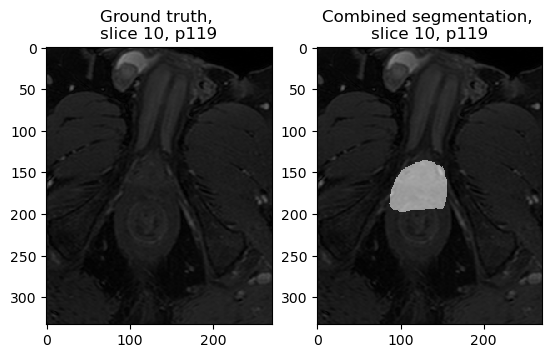

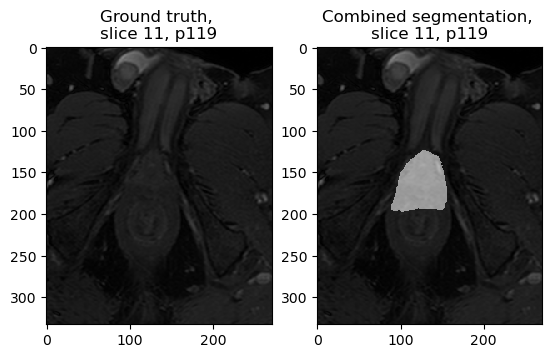

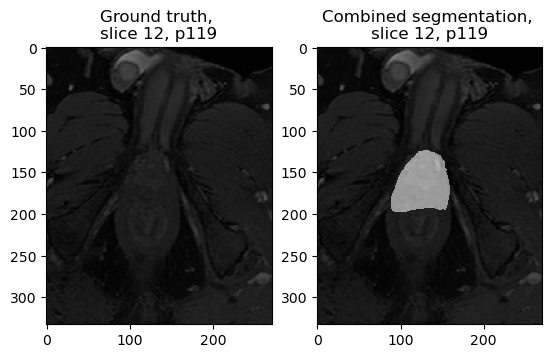

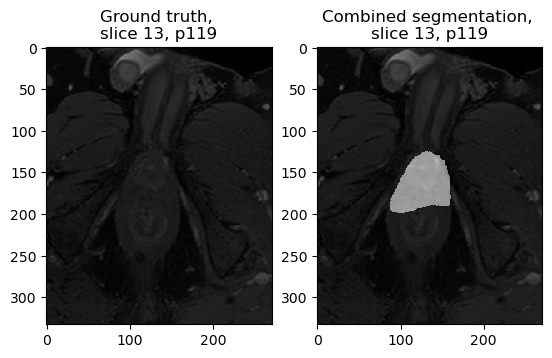

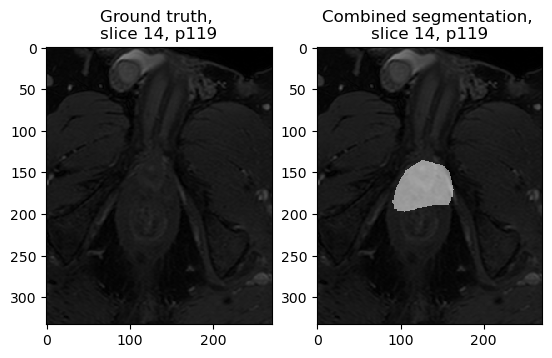

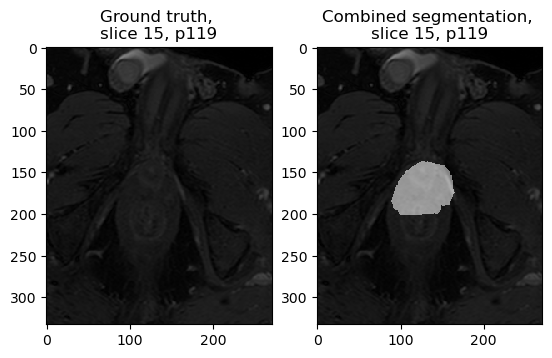

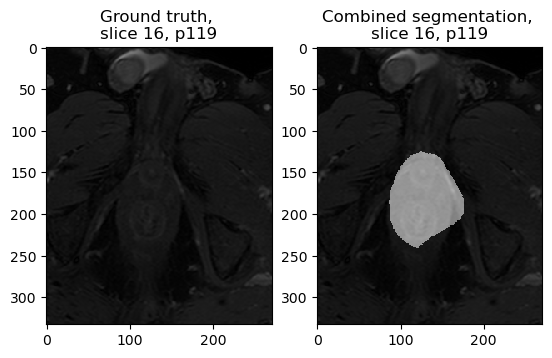

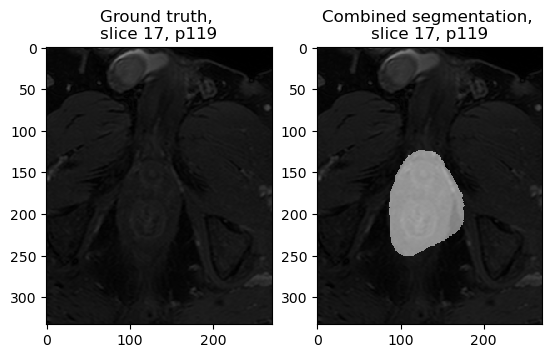

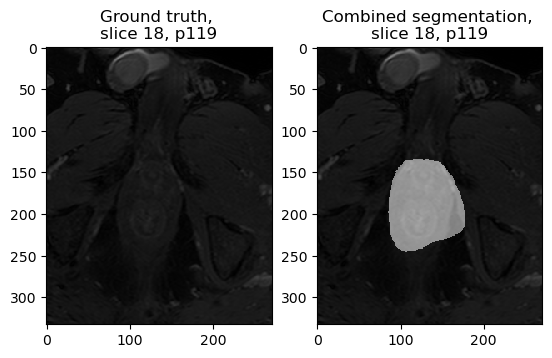

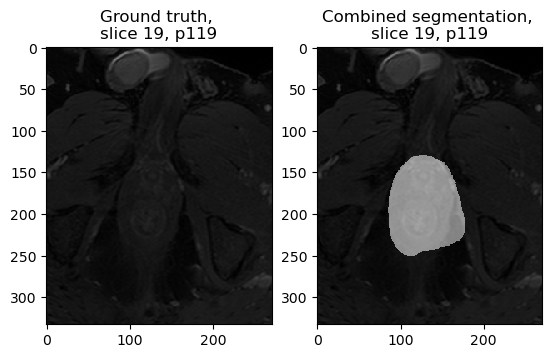

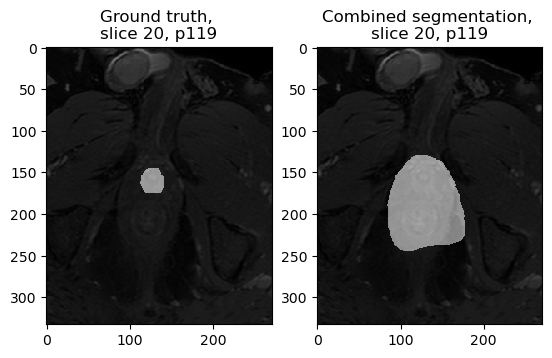

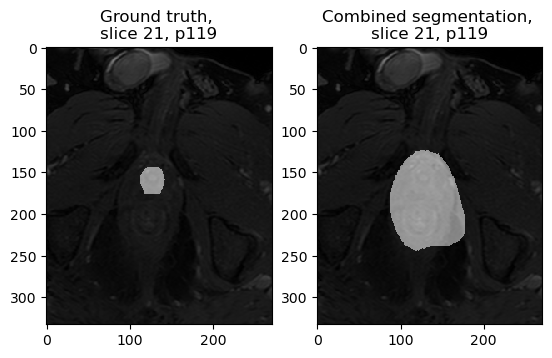

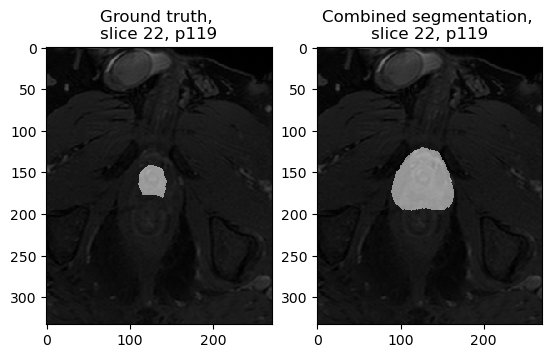

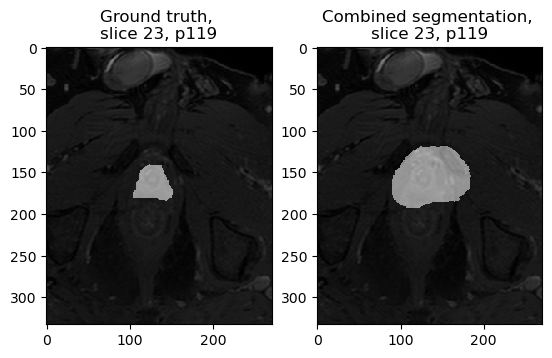

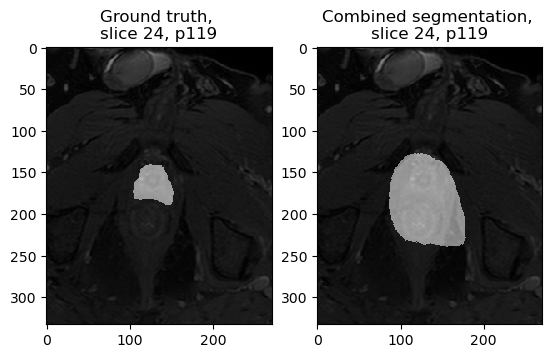

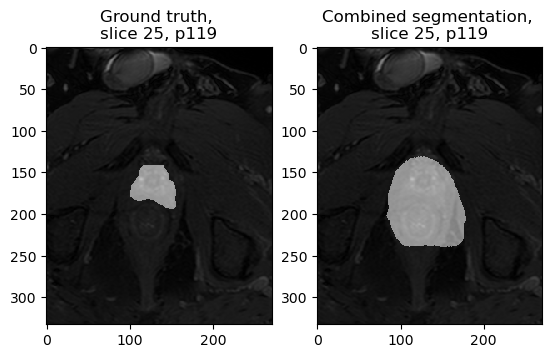

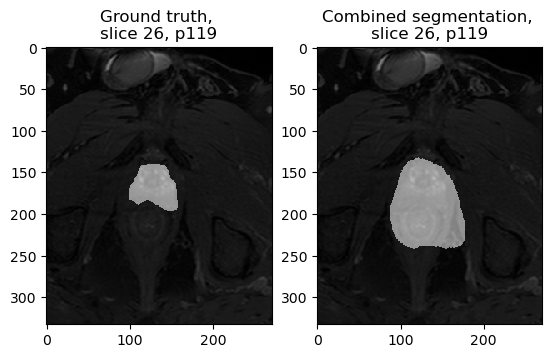

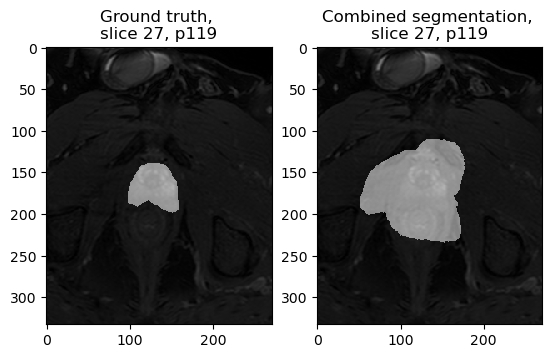

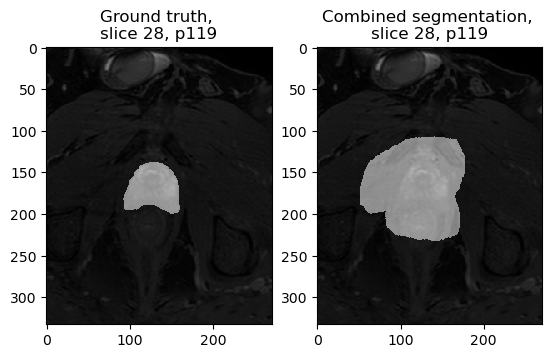

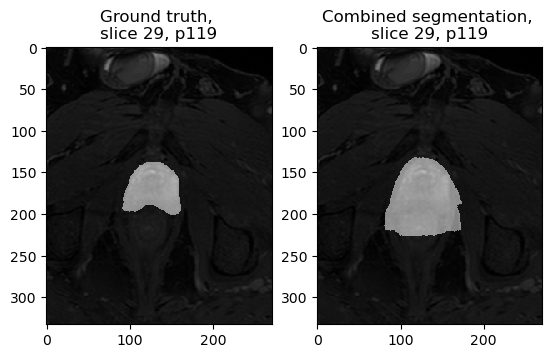

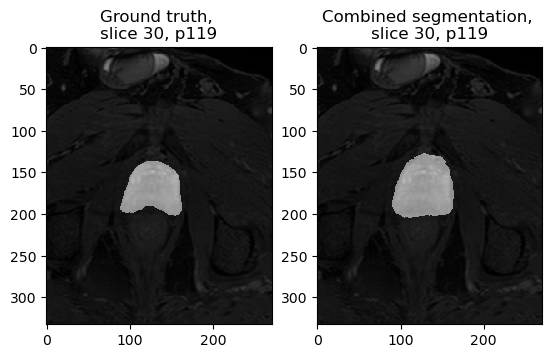

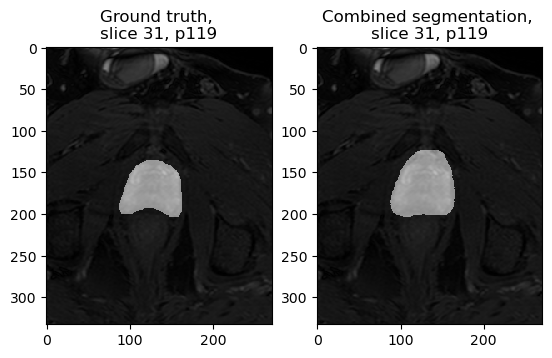

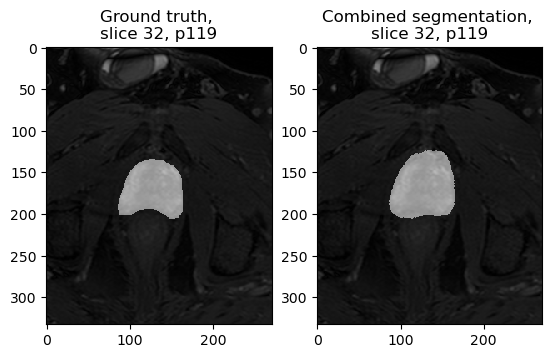

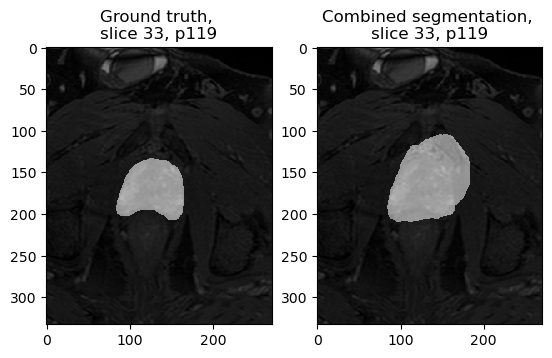

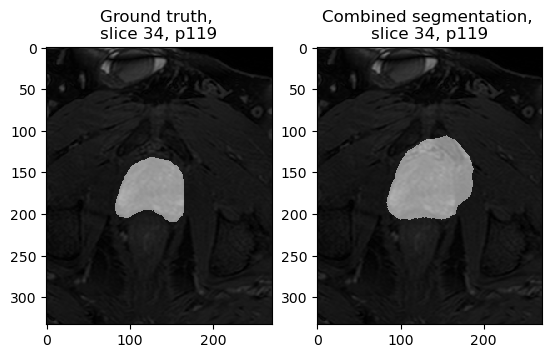

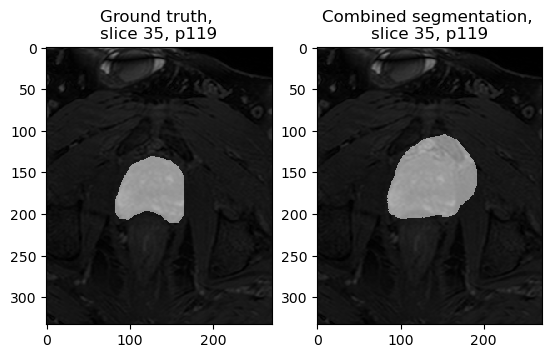

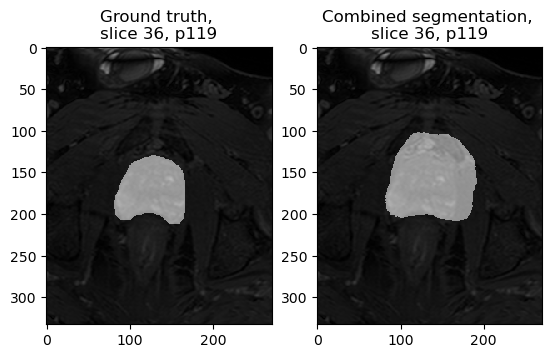

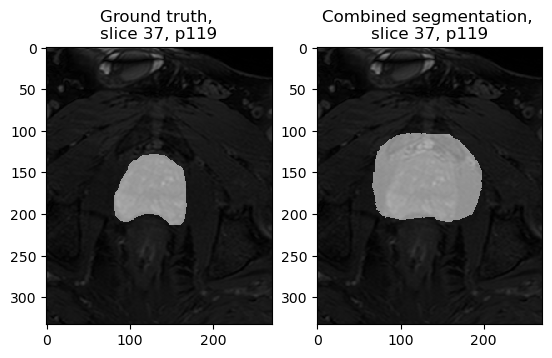

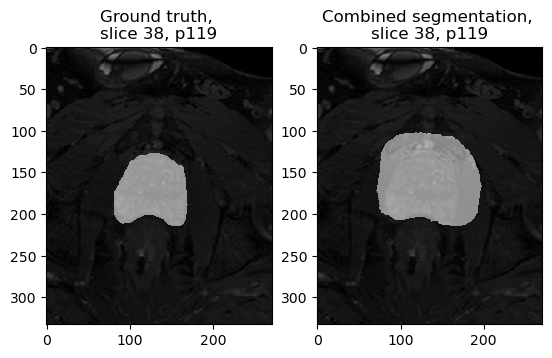

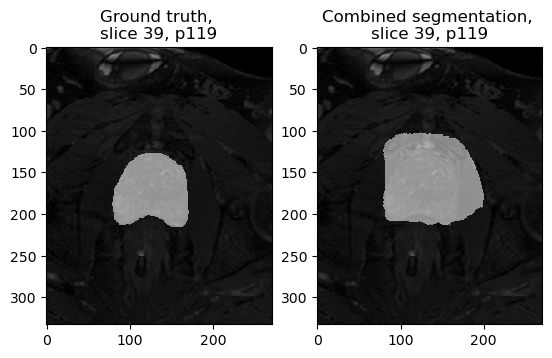

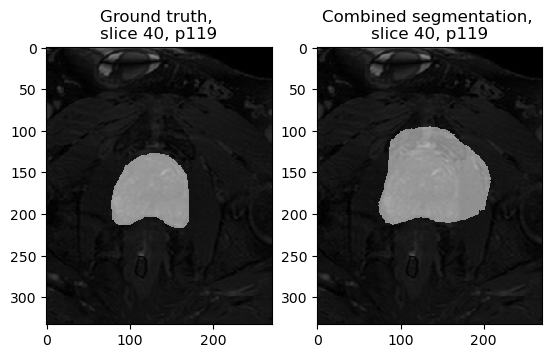

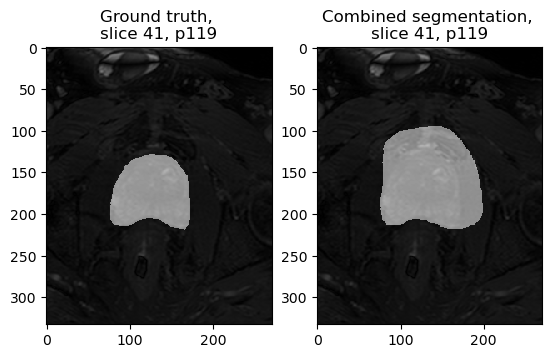

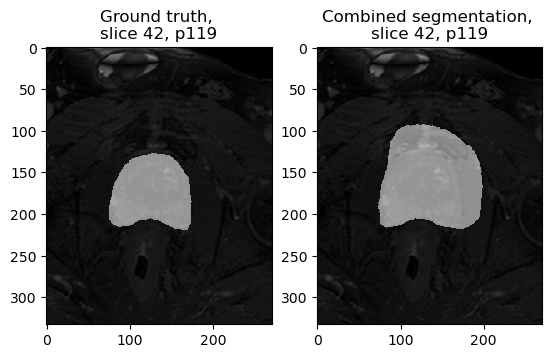

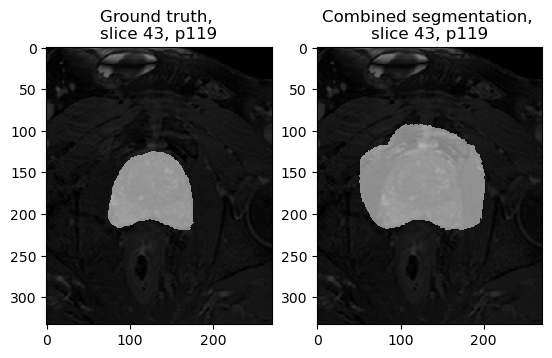

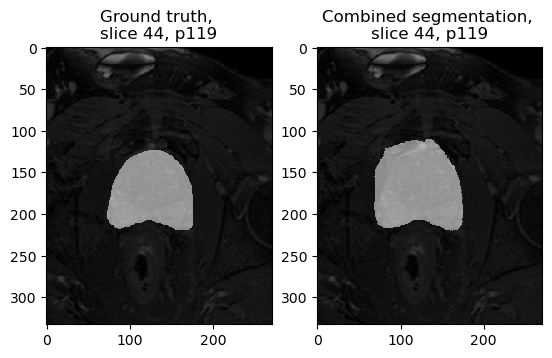

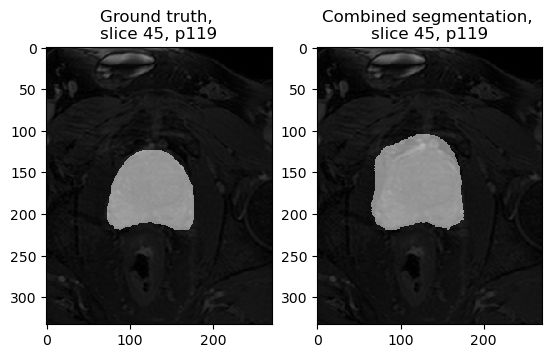

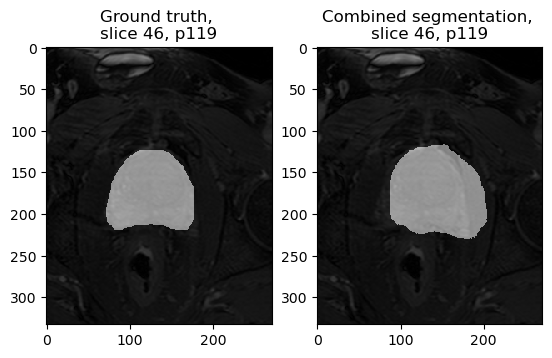

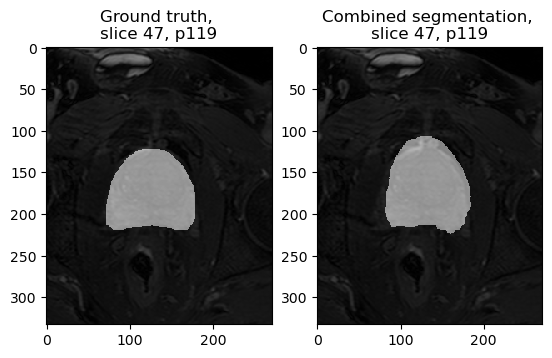

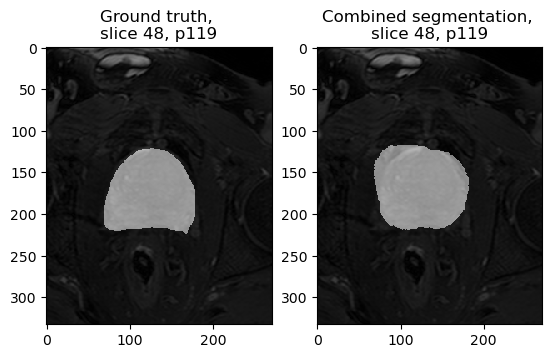

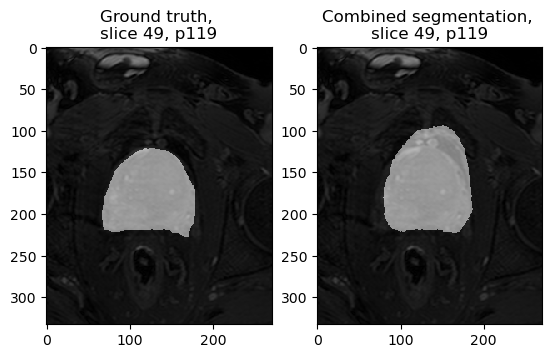

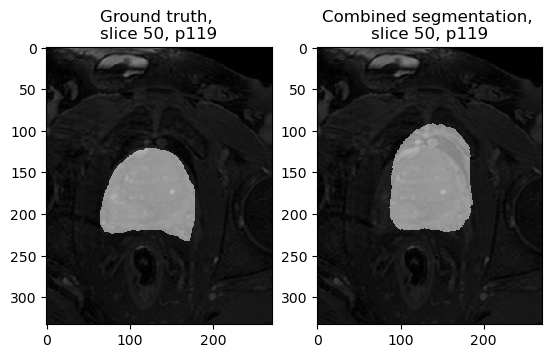

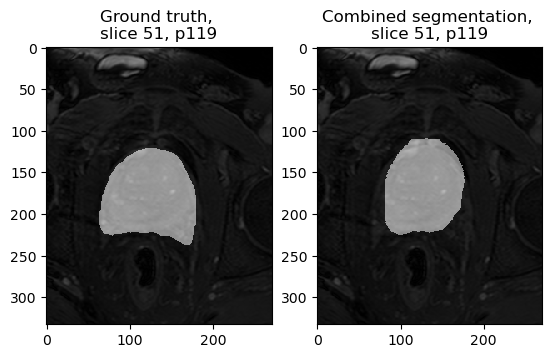

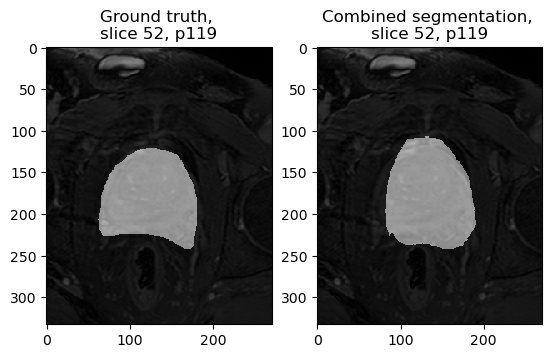

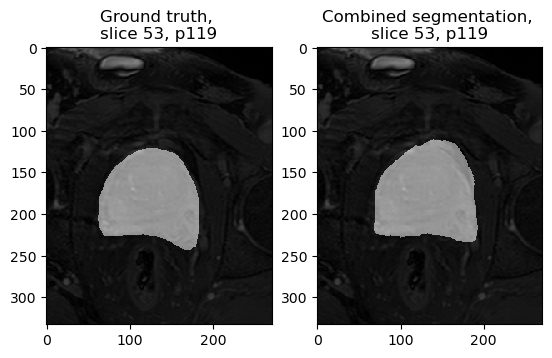

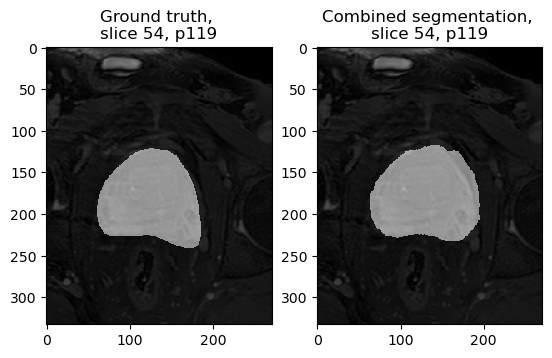

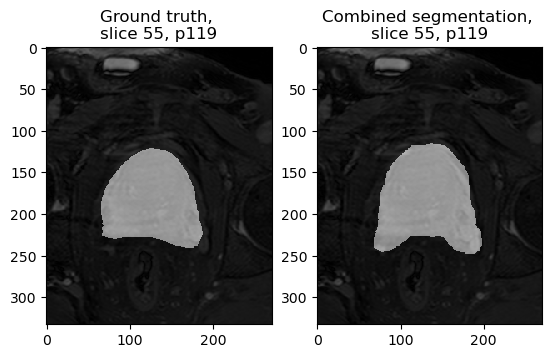

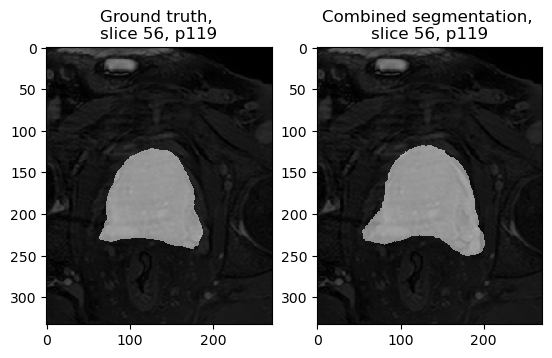

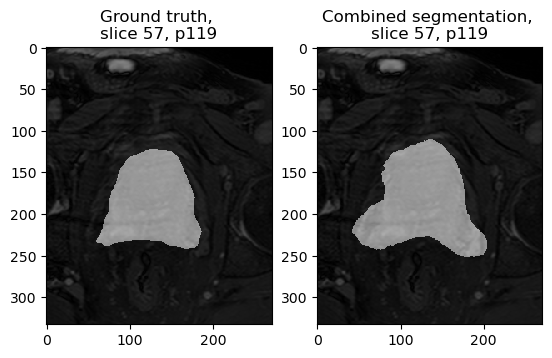

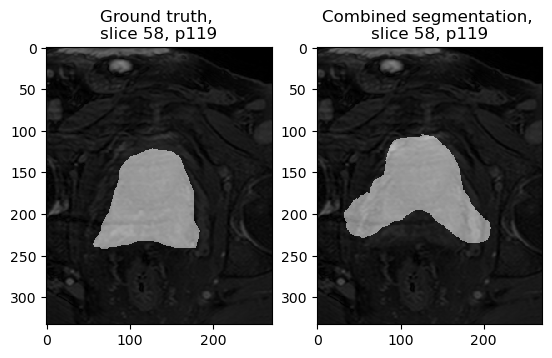

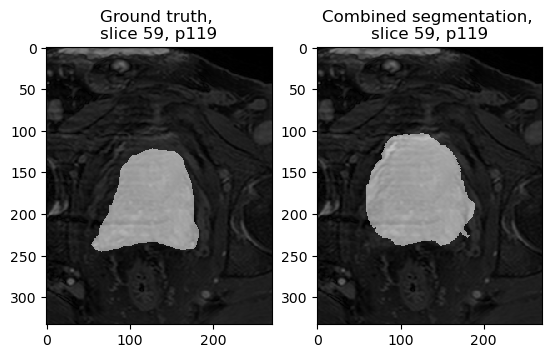

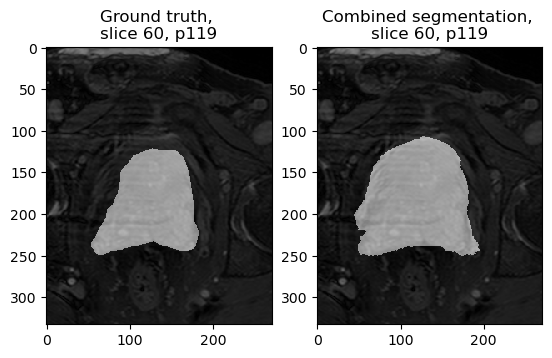

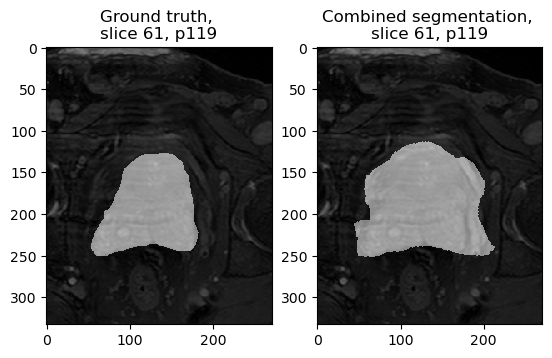

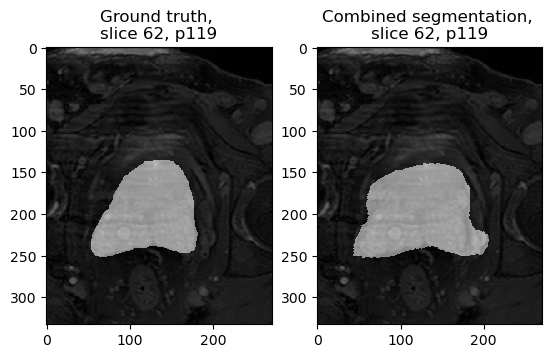

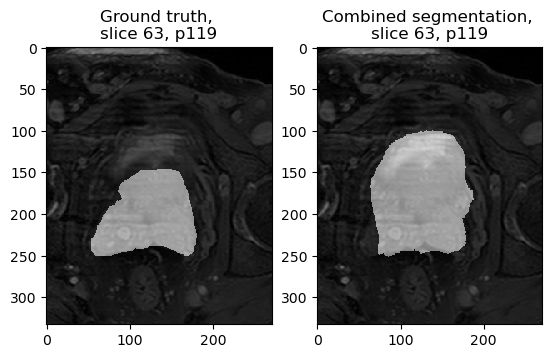

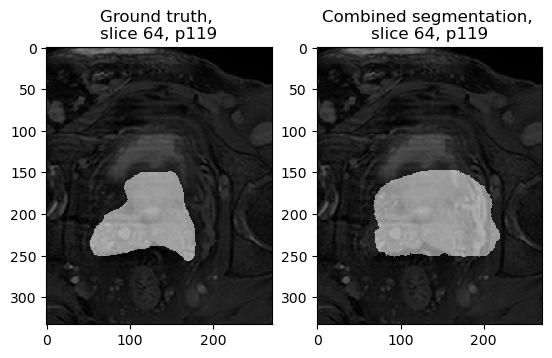

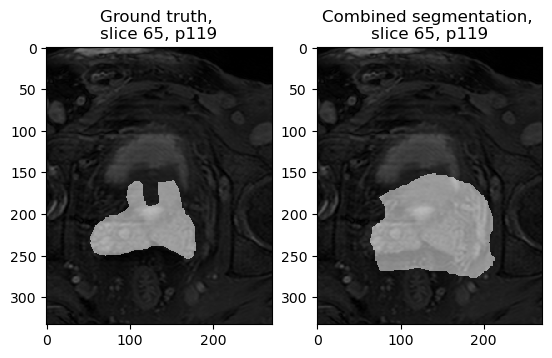

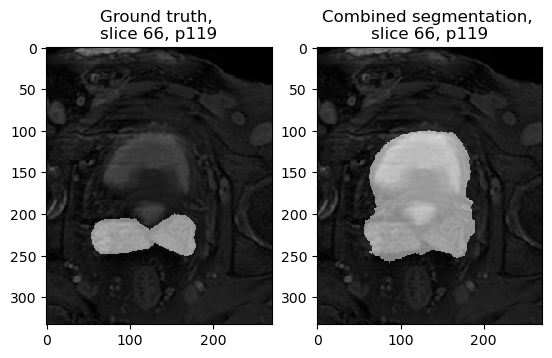

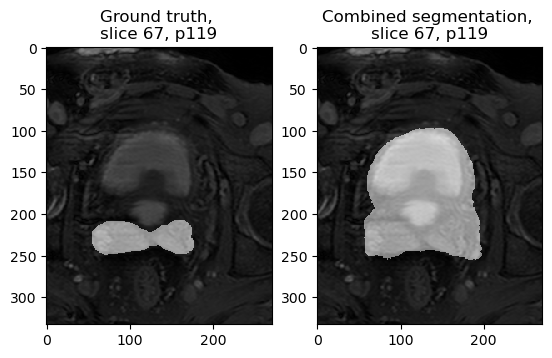

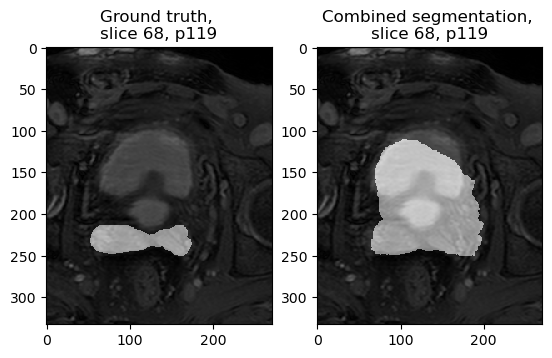

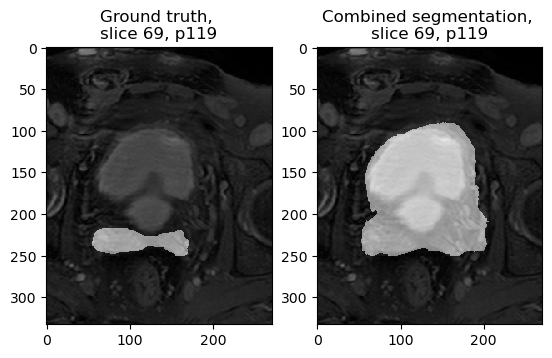

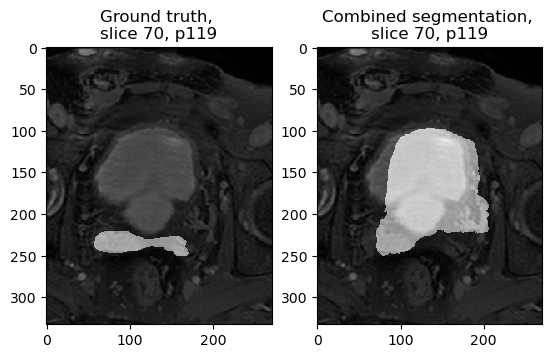

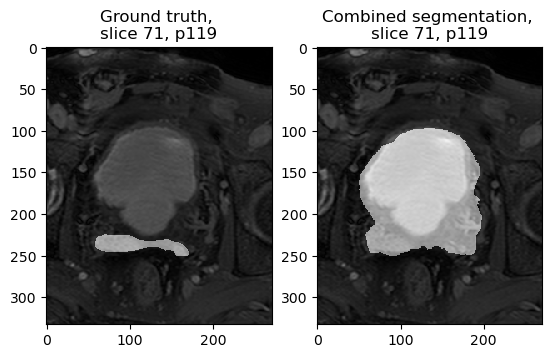

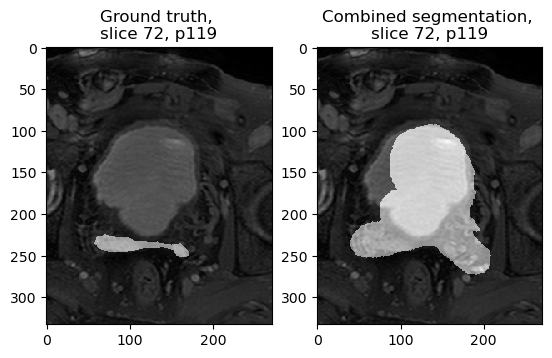

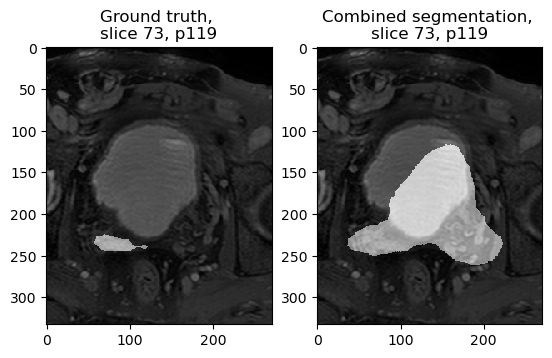

In [ ]:
## Visualization of results separately
for fixed_image_id in range(1):
    #fixed_image_id=0
    patient_id_fixed_image= test_pts[fixed_image_id]
    
    patient_nrs_moving= patient_nrs_list


    # select all but fixed image to use as moving image
    train_mr_list_moving = []
    for j in loaded_mr_list:
        train_mr_list_moving.append(j)
     
    fixed_image_mr_test, __= loadPatientDataReadable(patient_id_fixed_image, filepath=filepath_data)

    for image_slice_fixed in range(86): # when everything works: use 86. When everything is still being tested: keep it simple with 4. 

        #First get most similar slices (again)
#         print('Fixed image slice nr:', image_slice_fixed)

        list_of_list_MI, list_moving_slices_used = allMImovingImages(train_mr_list_moving, image_slice_fixed, fixed_image_mr)

        per_patient_per_slice_MI = intoOneList(list_of_list_MI)

        most_similar_list_index = sort_index(per_patient_per_slice_MI)[:5] # Get the five most similar images of all moving images

        patient_ids_similar = []
        slice_ids_similar = []
        for j in most_similar_list_index:
            patient_index_a, actual_slice_nr_a = getPatientAndSlice(j, list_moving_slices_used, train_mr_list_moving, patient_nrs_list, patient_nrs_moving)
            patient_ids_similar.append(patient_nrs_moving[patient_index_a])
            slice_ids_similar.append(actual_slice_nr_a)


    #     # Visualization of results
    #     #registration
    #     for work_down_list in range(len(patient_ids_similar)): # 0 to 5
    #         visualize_bspline_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
    #                              slice_ids_similar[work_down_list], filepath_data)
    #     #jacobian
    #     for work_down_list in range(len(patient_ids_similar)): # 0 to 5
    #         visualize_jacobian(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
    #                              slice_ids_similar[work_down_list], filepath_data, tr_path=TRANSFORMIX_PATH)
    #     #mask registration
    #     for work_down_list in range(len(patient_ids_similar)): # 0 to 5    
    #         visualize_bspline_mask_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
    #                              slice_ids_similar[work_down_list], filepath_data)
#         #mask overlay
#         for work_down_list in range(len(patient_ids_similar)): # 0 to 5    
#             overlay_mask(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
#                                  slice_ids_similar[work_down_list], filepath_data)
        
        #combined segmentation, overlays the masks over the original image
        #could also put this into a function    
        fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed) 
        result_path=os.path.join(filepath_data,patient_id_fixed_image, 'result_{}_slice{}.png'.format(patient_id_fixed_image,image_slice_fixed))
        fixed_image_path = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed)

        readable_fixed = imageio.imread(fixed_image_path)

        itk_mask_fixed = sitk.ReadImage(fixed_mask_path)
        mask_array_fixed = sitk.GetArrayFromImage(itk_mask_fixed)

        itk_mask_result= sitk.ReadImage(result_path)
        mask_array_result = sitk.GetArrayFromImage(itk_mask_result)

        fig,ax=plt.subplots(1,2)
        ax[0].imshow(readable_fixed[:,:], cmap='gray')
        ax[0].imshow(mask_array_fixed[:,:], cmap='gray', alpha=0.5)
        ax[0].set_title('Ground truth, \nslice {}, {}'.format(image_slice_fixed, patient_id_fixed_image))
        ax[1].imshow(readable_fixed[:,:], cmap='gray')
        ax[1].imshow(mask_array_result, cmap='gray', alpha=0.5)
        ax[1].set_title('Combined segmentation, \nslice {}, {}'.format(image_slice_fixed, patient_id_fixed_image))
